# SAMS vs REPEX Test Systems

### Test free energies for SAMS

In [6]:
# imports
%matplotlib inline
import matplotlib.pylab as plt
from simtk import openmm, unit
import scipy
import numpy as np
import math
import os
import openmmtools as mmtools
import yank
from yank.utils import config_root_logger
from netCDF4 import Dataset
import mpiplus

kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA

/Users/brucemah/miniconda3/envs/myenv/lib/python3.6/site-packages/openmmtools-0.17.0-py3.6-macosx-10.7-x86_64.egg/openmmtools/multistate/__init__.py:75: UserWarning: Warning: openmmtools.multistate API is experimental
  warnings.warn('Warning: openmmtools.multistate API is experimental')


In [7]:
def compute_harmonic_oscillator_expectations(K, temperature):
    """Compute mean and variance of potential and kinetic energies for a 3D harmonic oscillator.
    Notes
    -----
    Numerical quadrature is used to compute the mean and standard deviation of the potential energy.
    Mean and standard deviation of the kinetic energy, as well as the absolute free energy, is computed analytically.
    Parameters
    ----------
    K : simtk.unit.Quantity
        Spring constant.
    temperature : simtk.unit.Quantity
        Temperature.
    Returns
    -------
    values : dict
    """

    values = dict()

    # Compute thermal energy and inverse temperature from specified temperature.
    kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
    kT = kB * temperature  # thermal energy
    beta = 1.0 / kT  # inverse temperature

    # Compute standard deviation along one dimension.
    sigma = 1.0 / unit.sqrt(beta * K)

    # Define limits of integration along r.
    r_min = 0.0 * unit.nanometers  # initial value for integration
    r_max = 10.0 * sigma      # maximum radius to integrate to

    # Compute mean and std dev of potential energy.
    V = lambda r : (K/2.0) * (r*unit.nanometers)**2 / unit.kilojoules_per_mole # potential in kJ/mol, where r in nm
    q = lambda r : 4.0 * math.pi * r**2 * math.exp(-beta * (K/2.0) * (r*unit.nanometers)**2) # q(r), where r in nm
    (IqV2, dIqV2) = scipy.integrate.quad(lambda r : q(r) * V(r)**2, r_min / unit.nanometers, r_max / unit.nanometers)
    (IqV, dIqV)   = scipy.integrate.quad(lambda r : q(r) * V(r), r_min / unit.nanometers, r_max / unit.nanometers)
    (Iq, dIq)     = scipy.integrate.quad(lambda r : q(r), r_min / unit.nanometers, r_max / unit.nanometers)
    values['potential'] = dict()
    values['potential']['mean'] = (IqV / Iq) * unit.kilojoules_per_mole
    values['potential']['stddev'] = (IqV2 / Iq) * unit.kilojoules_per_mole

    # Compute mean and std dev of kinetic energy.
    values['kinetic'] = dict()
    values['kinetic']['mean'] = (3./2.) * kT
    values['kinetic']['stddev'] = math.sqrt(3./2.) * kT

    # Compute dimensionless free energy.
    # f = - \ln \int_{-\infty}^{+\infty} \exp[-\beta K x^2 / 2]
    #   = - \ln \int_{-\infty}^{+\infty} \exp[-x^2 / 2 \sigma^2]
    #   = - \ln [\sqrt{2 \pi} \sigma]
    values['f'] = - np.log(2 * np.pi * (sigma / unit.angstroms)**2) * (3.0/2.0)

    return values

In [8]:
def run_harmonic_test(sim_type,make_graphs=True,n_iterations=610,flatness_criteria='minimum-visits',
                      flatness_threshold=0.2,online_analysis_interval=1,stages='two-stage'):
    """Test harmonic oscillator free energies for SAMS.
    Adapted from Yank/tests/test_restraints.py 'test_harmonic_free_energy'
    """
    
    if sim_type not in ['SAMS','REPEX']:
        print('sim_type needs to be SAMS or REPEX')
        return
    
    
    #HARMONIC OSCILLATOR
    # Define mass of carbon atom.
    mass = 12.0 * unit.amu

    sampler_states = list()
    thermodynamic_states = list()
    analytical_results = list()
    f_i_analytical = list()  # Dimensionless free energies.
    u_i_analytical = list()  # Reduced potentials.

    # Define thermodynamic states.
 #   Ks = [600.0, 500.00, 400.0, 300.0] * unit.kilocalories_per_mole / unit.angstroms**2  # Spring constants.
    Ks = [300., 300., 300.]* unit.kilocalories_per_mole / unit.angstroms**2
    temperatures = [300.,400.,500.]* unit.kelvin 
  #  temperatures = [250.0, 300.0, 350.0, 400.0] * unit.kelvin  # Temperatures.
    for (K, temperature) in zip(Ks, temperatures):
        # Create harmonic oscillator system.
        testsystem = mmtools.testsystems.HarmonicOscillator(K=K, mass=mass, mm=openmm)

        # Create thermodynamic state and save positions.
        system, positions = [testsystem.system, testsystem.positions]
        sampler_states.append(mmtools.states.SamplerState(positions))
        thermodynamic_states.append(mmtools.states.ThermodynamicState(system=system, temperature=temperature))

        # Store analytical results.
        results = compute_harmonic_oscillator_expectations(K, temperature)
        analytical_results.append(results)
        f_i_analytical.append(results['f'])
        reduced_potential = results['potential']['mean'] / (kB * temperature)
        u_i_analytical.append(reduced_potential)

    # Compute analytical Delta_f_ij
    nstates = len(f_i_analytical)
    f_i_analytical = np.array(f_i_analytical)
    Delta_f_ij_analytical = np.zeros([nstates, nstates], np.float64)
    for i in range(nstates):
        for j in range(nstates):
            Delta_f_ij_analytical[i, j] = f_i_analytical[j] - f_i_analytical[i]


    # Define file for temporary storage.
    with mmtools.utils.temporary_directory() as tmp_dir:
        storage = os.path.join(tmp_dir, 'test_storage.nc')
        reporter = mmtools.multistate.MultiStateReporter(storage, checkpoint_interval=1)
        
        move = mmtools.mcmc.LangevinDynamicsMove(timestep=2.0*unit.femtoseconds,
                                                 collision_rate=20.0/unit.picosecond,
                                                 n_steps=500, reassign_velocities=True)        

        if sim_type == 'SAMS':
            simulation_sampler = mmtools.multistate.SAMSSampler(mcmc_moves=move, number_of_iterations=n_iterations,
                                 state_update_scheme='global-jump', flatness_threshold=flatness_threshold,
                                 update_stages=stages, flatness_criteria=flatness_criteria,minimum_visits=10, online_analysis_minimum_iterations=0,
                                 weight_update_method='rao-blackwellized',online_analysis_interval=online_analysis_interval)
        elif sim_type == 'REPEX':
            simulation_sampler = mmtools.multistate.ReplicaExchangeSampler(mcmc_moves=move, number_of_iterations=n_iterations,online_analysis_minimum_iterations=0,
                                                                        online_analysis_interval=online_analysis_interval)
        else:
            print('simulation must be SAMS or REPEX')
            quit()
  
        simulation_sampler.create(thermodynamic_states, sampler_states, reporter)

        simulation_sampler.run()

#         # Create Analyzer.

        if sim_type == 'SAMS':
            analyzer = mmtools.multistate.SAMSAnalyzer(reporter)
        elif sim_type == 'REPEX':
            analyzer = mmtools.multistate.ReplicaExchangeAnalyzer(reporter)
            
#         Delta_f_ij, dDelta_f_ij = analyzer.get_free_energy()
#         print('Free energy: {}'.format(Delta_f_ij))
#         print('analytical result: {}'.format(Delta_f_ij_analytical))

        if make_graphs:
            ncfile = Dataset(storage, 'r')
            free_energy_history = ncfile.groups['online_analysis'].variables['free_energy_history']
            fig = plt.figure(figsize=(10,5));
            plt.plot([x[0] for x in free_energy_history],'.');
            plt.xlabel('iteration');
            plt.ylabel('dG / kT');
#             plt.title(simulation.flatness_criteria)  
            
            if sim_type == 'SAMS':
                t0 = ncfile.groups['online_analysis'].variables['t0_history'][-1]
                print('Switched to asymptotically optimal scheme after {} steps'
                  .format(t0))
                logZ = analyzer.read_logZ()
                n_states, n_iterations = logZ.shape
                fig = plt.figure(figsize=(10,5));
                plt.plot(np.transpose(logZ));
                plt.xlabel('iteration');
                plt.ylabel('logZ / kT');
#                 plt.title(simulation.flatness_criteria)


                states = ncfile.variables['states']
                n_iterations, n_replicas = states.shape
                fig = plt.figure(figsize=(10,5));
                plt.plot(states,'.');
                plt.xlabel('iteration');
                plt.ylabel('thermodynamic state');
                plt.axis([0, n_iterations, 0, n_states]);
#                 plt.title(simulation.flatness_criteria)

                gamma = ncfile.groups['online_analysis'].variables['gamma_history']
                n_iterations, n_replicas = states.shape

                fig = plt.figure(figsize=(10,5));
                plt.plot(gamma,'.');
                plt.xlabel('iteration');
                plt.ylabel('gamma');
#                 plt.title(simulation.flatness_criteria)
            
        return analyzer

# Harmonic oscillator
### Running harmonic system with range of convergence metrics

In [5]:
# for method in ['minimum-visits','histogram-flatness','logZ-flatness']:
title = ['default','online','offline']    
online_freq = [200,1,1000]

# for fig_title, freq in zip(title,online_freq):    
_ = run_harmonic_test('SAMS',n_iterations=20)


NameError: name 'unit' is not defined

Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
Entering second stage at 14 steps
Switched to asymptotically optimal scheme after [13] steps


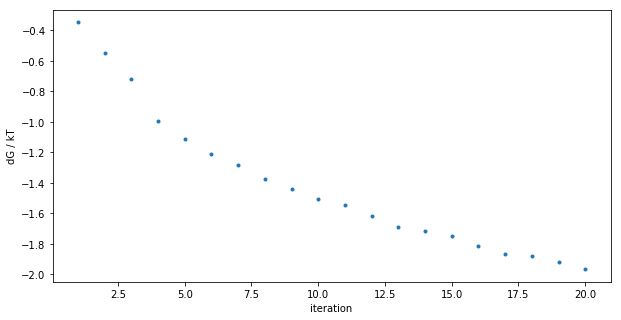

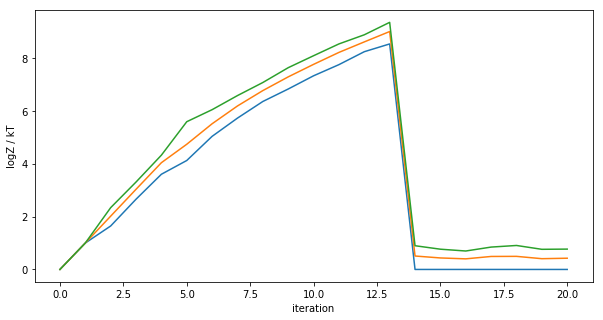

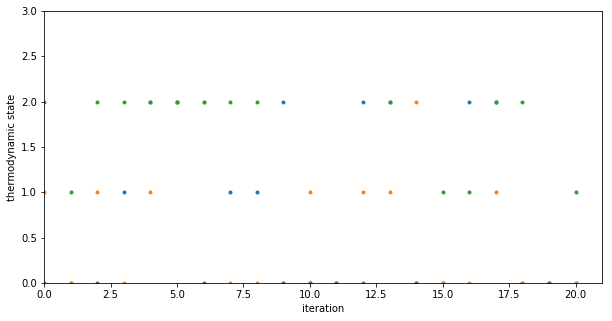

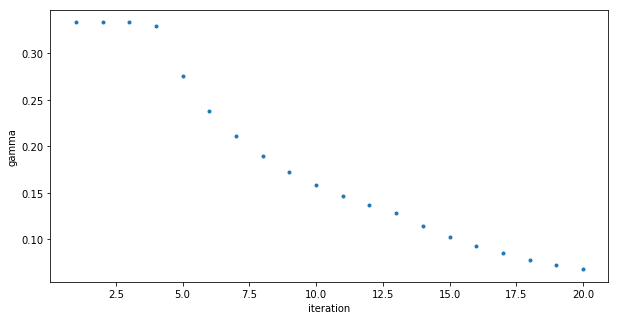

In [6]:
_ = run_harmonic_test('SAMS',n_iterations=20,stages='three-stage')

Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
Switched to asymptotically optimal scheme after [0] steps


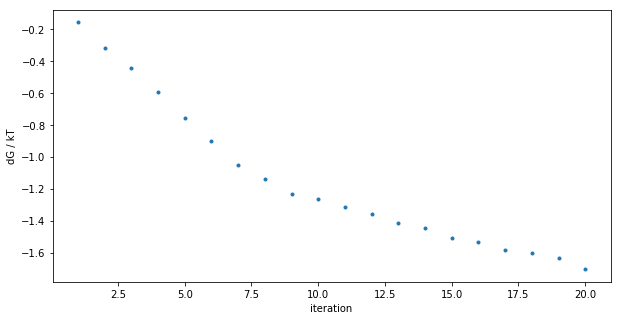

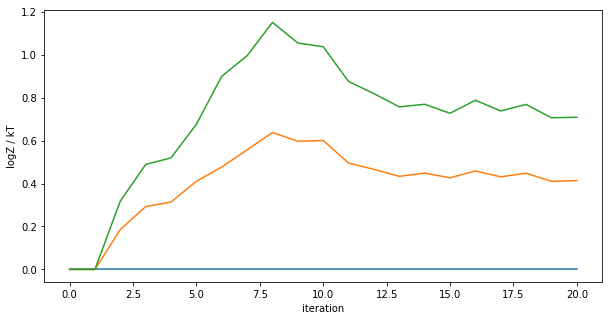

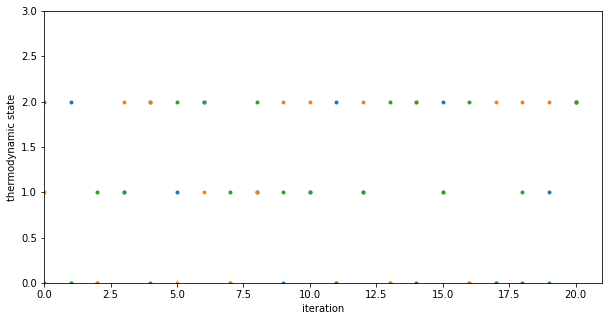

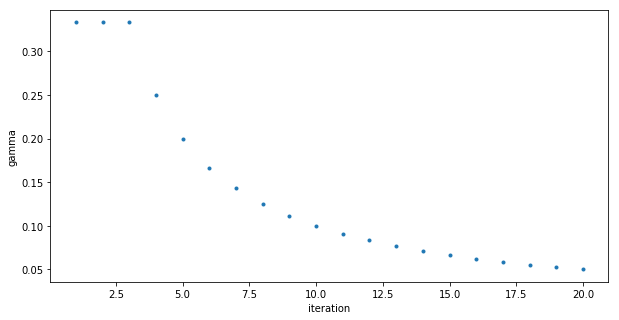

In [7]:
_ = run_harmonic_test('SAMS',n_iterations=20,stages='one-stage')

In [9]:
def lambda_parameters(l):
    sterics = np.heaviside(l-0.5,0.5) + 2*l*np.heaviside(0.5-l,0.5)
    ele = 2*(l-0.5)*np.heaviside(l-0.5,0.)
    return sterics, ele


def run_toluene_test(sim_type,make_graphs=True,n_iterations=610,flatness_criteria='logZ-flatness',flatness_threshold=0.2,online_analysis_interval=200,n_lambda=21,update_stages='two-stage'):
    """Test harmonic oscillator free energies for SAMS.
    Adapted from Yank/tests/test_restraints.py 'test_harmonic_free_energy'
    """
    
    if sim_type not in ['SAMS','REPEX']:
        print('sim_type needs to be SAMS or REPEX')
        return
    
    
    sampler_states = list()
    thermodynamic_states = list()

    toluenesystem = mmtools.testsystems.TolueneImplicitGBn()
    toluene_atoms = toluenesystem.mdtraj_topology.select('resname TOL')
    alchemical_region = mmtools.alchemy.AlchemicalRegion(alchemical_atoms=toluene_atoms)

    factory = mmtools.alchemy.AbsoluteAlchemicalFactory()
    alchemical_system = factory.create_alchemical_system(toluenesystem.system, alchemical_region)
    f_electrostatics = '2*(lambda-0.5)*step(lambda-0.5)'
    f_sterics = '2*lambda*step_hm(0.5-lambda) + step_hm(lambda-0.5)'

    
    for l in np.linspace(0.,1.,n_lambda):
        integrator = mmtools.integrators.LangevinIntegrator()
        context = openmm.Context(alchemical_system, integrator)
        context.setPositions(toluenesystem.positions)
        alchemical_state = mmtools.alchemy.AlchemicalState()
        alchemical_state = mmtools.alchemy.AlchemicalState.from_system(alchemical_system)

        alchemical_state.lambda_sterics, alchemical_state.lambda_electrostatics = lambda_parameters(l)
        alchemical_state.apply_to_context(context)
        thermodynamic_state = mmtools.states.ThermodynamicState(system=alchemical_system,temperature=300*unit.kelvin)
        thermodynamic_states.append(mmtools.states.CompoundThermodynamicState(thermodynamic_state=thermodynamic_state,composable_states=[alchemical_state]))
    sampler_states.append(mmtools.states.SamplerState(toluenesystem.positions)) # only one sampling state, might need more

    # Define file for temporary storage.
    with mmtools.utils.temporary_directory() as tmp_dir:
        storage = os.path.join(tmp_dir, 'test_storage.nc')
        reporter = mmtools.multistate.MultiStateReporter(storage, checkpoint_interval=1)
        
        move = mmtools.mcmc.LangevinDynamicsMove(timestep=2.0*unit.femtoseconds,
                                                 collision_rate=20.0/unit.picosecond,
                                                 n_steps=500, reassign_velocities=True)        

        if sim_type == 'SAMS':
            simulation_sampler = mmtools.multistate.SAMSSampler(mcmc_moves=move, number_of_iterations=n_iterations,
                                 state_update_scheme='global-jump', flatness_threshold=flatness_threshold,
                                 update_stages=update_stages, flatness_criteria=flatness_criteria,
                                 weight_update_method='rao-blackwellized',online_analysis_interval=online_analysis_interval)
        elif sim_type == 'REPEX':
            simulation_sampler = mmtools.multistate.ReplicaExchangeSampler(mcmc_moves=move, number_of_iterations=n_iterations,
                                                                        online_analysis_interval=online_analysis_interval)
        else:
            print('simulation must be SAMS or REPEX')
            quit()
  
        simulation_sampler.create(thermodynamic_states, sampler_states, reporter)
        print('minimizing')
        simulation_sampler.minimize()
        print('minimization complete')
        simulation_sampler.run()

#         # Create Analyzer.

        if sim_type == 'SAMS':
            analyzer = mmtools.multistate.SAMSAnalyzer(reporter)
        elif sim_type == 'REPEX':
            analyzer = mmtools.multistate.ReplicaExchangeAnalyzer(reporter)
            
        if make_graphs:
            ncfile = Dataset(storage, 'r')
            free_energy_history = ncfile.groups['online_analysis'].variables['free_energy_history']
            fig = plt.figure(figsize=(10,5));
            plt.plot([x[0] for x in free_energy_history],'.');
            plt.xlabel('iteration');
            plt.ylabel('dG / kT');
#             plt.title(simulation.flatness_criteria)  
            
            if sim_type == 'SAMS':
                t0 = ncfile.groups['online_analysis'].variables['t0_history'][-1]
                print('Switched to asymptotically optimal scheme after {} steps'
                  .format(t0))
                logZ = analyzer.read_logZ()
                n_states, n_iterations = logZ.shape
                fig = plt.figure(figsize=(10,5));
                plt.plot(np.transpose(logZ));
                plt.xlabel('iteration');
                plt.ylabel('logZ / kT');
#                 plt.title(simulation.flatness_criteria)


                states = ncfile.variables['states']
                n_iterations, n_replicas = states.shape
                fig = plt.figure(figsize=(10,5));
                plt.plot(states,'.');
                plt.xlabel('iteration');
                plt.ylabel('thermodynamic state');
                plt.axis([0, n_iterations, 0, n_states]);
#                 plt.title(simulation.flatness_criteria)

                gamma = ncfile.groups['online_analysis'].variables['gamma_history']
                n_iterations, n_replicas = states.shape

                fig = plt.figure(figsize=(10,5));
                plt.plot(gamma,'.');
                plt.xlabel('iteration');
                plt.ylabel('gamma');
#                 plt.title(simulation.flatness_criteria)
            
        return analyzer

# Toluene Implicit
## Testing SAMS with atomistic system

In [11]:
_ = run_toluene_test('SAMS',n_iterations=2000,n_lambda=21,flatness_threshold=0.2,online_analysis_interval=1)

Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
minimizing
minimization complete
Entering second stage at 36 steps


SystemError: <built-in function Context_getState> returned a result with an error set

/Users/brucemah/miniconda3/envs/myenv/lib/python3.6/site-packages/simtk/openmm/app/internal/amber_file_parser.py:1017: UserWarning: Non-optimal GB parameters detected for GB model GBn
  'Non-optimal GB parameters detected for GB model %s' % gbmodel)


Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
minimizing
minimization complete
Entering second stage at 36 steps


/Users/brucemah/miniconda3/envs/myenv/lib/python3.6/site-packages/numpy/core/numeric.py:553: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


Switched to asymptotically optimal scheme after [35] steps


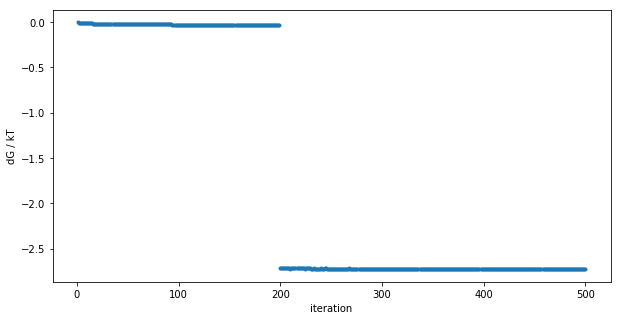

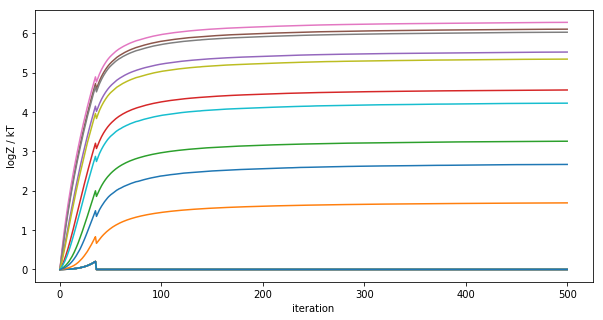

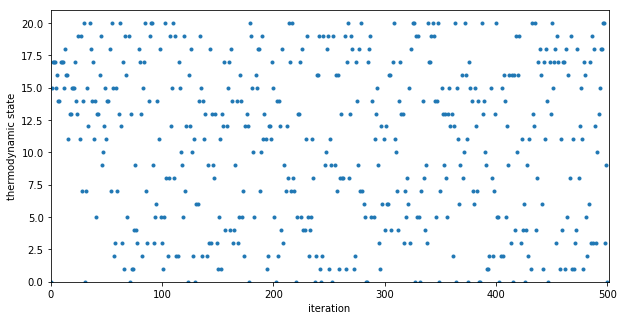

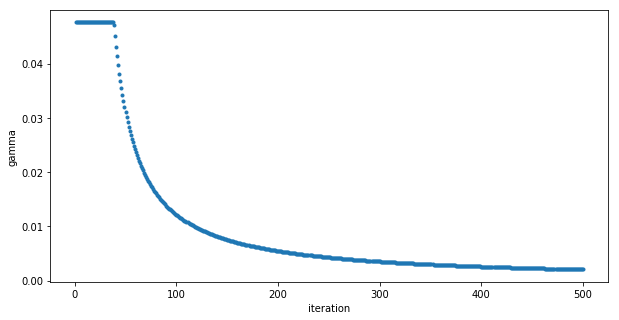

In [36]:
_ = run_toluene_test('SAMS',n_iterations=500,n_lambda=21,flatness_threshold=0.2,
                     online_analysis_interval=1,update_stages='three-stage')

_ = run_toluene_test('REPEX',n_iterations=500,n_lambda=21,flatness_threshold=0.2,online_analysis_interval=1)